In [ ]:
import numpy as np
import quantum_stuff as qs
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots
import sklearn.linear_model as LM
from scipy.special import comb
import nolds

plt.style.use(['science', 'no-latex'])

sx = qs.sigmax()
sy = qs.sigmay()
sz = qs.sigmaz()
I = np.eye(2)

In [19]:
def encoding(uk):
    op = np.einsum('i, jk -> ijk', (1-2*uk), qs.sigmaz())
    return 0.5*(I+op)

In [20]:
Nq = 5
Js = 2
δt = 10/(0.5*Js)

wo = 1000
train_size = 2000
test_size = 2000
dim = wo + train_size + test_size

In [21]:
sk = qs.MackeyGlass(steps = dim + 200)[217:]
ρ = qs.FNencoding(sk, basis = 'z', dm = True)

In [ ]:
Δ = 1
Δ2 = 0
W = Δ2*Js
J = qs.random_coupling(Js, Nq)
D = np.random.uniform(-W, W, size = Nq)
h = Δ*Js

In [28]:
Z = qs.local_operators(sz, Nq)
Y = qs.local_operators(sy, Nq)
X = qs.local_operators(sx, Nq)

In [ ]:
H = qs.interaction(X, J) + np.dot((h + D),np.transpose(Z, (1, 0, 2)))

Memory Test

In [ ]:
ρ_res = [qs.random_qubit(Nq-1, dm = True) for i in range(2)]

In [ ]:
tstep = 1
outputs_traced = np.zeros((2, dim, 2**(Nq-1), 2**(Nq-1)), dtype = complex)
for i in tqdm(range(2)):
    outputs = qs.collisions(ρ, ρ_res[i], H, δt, tstep)
    outputs_traced[i] = qs.ptrace(outputs, [k for k in range(1,Nq)])

SyntaxError: expected ':' (1349764335.py, line 3)

In [10]:
dist = np.real(qs.distance(outputs_traced[0], outputs_traced[1]))

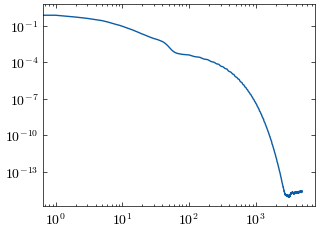

In [11]:
plt.loglog(dist)

In [ ]:
xx = np.kron(sx, sx)
yy = np.kron(sy,sy)
zz = np.kron(sz,sz)
operators = [sx, sy, sz, xx, yy, zz]
x = np.zeros((dim, int(3*Nq + 3*comb(Nq, 2))))

In [13]:
ρ_wo = ρ[:wo]
ρ_train = ρ[wo:wo + train_size]
output = qs.collisions(ρ_wo, ρ_res[0], H, δt, tstep)
ρ_res = qs.ptrace(output[-1], list(range(1, Nq)))
output_train = qs.collisions(ρ_train, ρ_res, H, δt, tstep)
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))

In [ ]:
x = np.hstack((qs.local_measurements(output_train), qs.two_qubits_measurements(output_train, [xx, yy, zz]), np.ones((train_size, 1))))
ridge = LM.Ridge(alpha = 0.4e-5)
y_target = sk[wo+1:wo+train_size+1]
ridge.fit((x), y_target)


Ridge(alpha=4e-06)

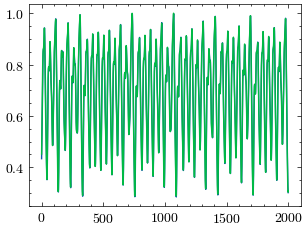

In [15]:
plt.plot(range(train_size),sk[wo:wo+train_size], range(train_size), ridge.predict(x))

In [ ]:
ρ_in = ρ[wo + train_size][np.newaxis]
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))
y_pred = np.zeros(test_size)
x_test = []
for i in range(test_size):
    output_test = qs.collisions(ρ_in, ρ_res_test, H, δt, tstep)
    ρ_res_test = qs.ptrace(output_test[0], list(range(1,Nq)))
    x_test.append(np.hstack((qs.local_measurements(output_test), qs.two_qubits_measurements(output_test, [xx, yy, zz]), np.ones((1, 1)))))
    y_pred[i] = ridge.predict(x_test[i])
    if y_pred[i] < 0:
        y_pred[i] = 0
    ρ_in = qs.FNencoding(y_pred[np.newaxis, i], basis = 'z', dm = True)

C:\Users\marco\AppData\Local\Temp\ipykernel_16640\802914115.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_16640\802914115.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_16640\802914115.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\marco\AppData\Local\Temp\ipykernel_16640\802914115.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is d

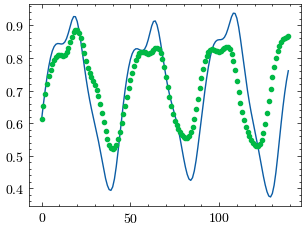

In [311]:
plt.plot(range(test_size)[:140], sk[wo + train_size+1:][:140], range(test_size)[:140], y_pred[:140], '.')

Ensemble test

In [16]:
s_test = sk[wo + train_size:]
ρ_test = qs.FNencoding(s_test, 'z', dm = True)
res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))
output_test = qs.collisions(ρ_test, res_test, H, δt, tstep)
r_test = np.hstack((local_measurements(output_test), two_qubits_measurements(output_test, [xx, yy, zz])))

In [347]:
([s_test[i+1] - s_test [i] for i in range(test_size-1)])

[np.float64(0.047328191368515404),
 np.float64(0.0457191235375749),
 np.float64(0.04266403787837092),
 np.float64(0.038528119932824234),
 np.float64(0.03331409324207746),
 np.float64(0.027040481822374285),
 np.float64(0.02008555172406734),
 np.float64(0.013160026862909291),
 np.float64(0.007022183302634155),
 np.float64(0.002297079012630765),
 np.float64(-0.0005242386933306253),
 np.float64(-0.001057753522680449),
 np.float64(0.0008937373132910098),
 np.float64(0.005134197250583505),
 np.float64(0.010858266304749953),
 np.float64(0.01655792111468135),
 np.float64(0.020073755831271467),
 np.float64(0.018987428650237947),
 np.float64(0.011820140171078575),
 np.float64(-0.0004300612556656924),
 np.float64(-0.014356443253639939),
 np.float64(-0.02631250624239523),
 np.float64(-0.03433859857489896),
 np.float64(-0.03829044511372848),
 np.float64(-0.038963228646613945),
 np.float64(-0.03734766965625569),
 np.float64(-0.03433999424091938),
 np.float64(-0.03074089046884354),
 np.float64(-0.027

In [231]:
n = 500
ϵ = 0.001
ind = np.unique(np.array(sorted(np.random.uniform(wo + train_size, dim, n)), dtype = int))

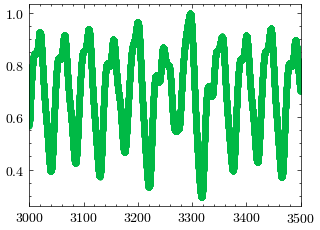

In [312]:
from scipy.interpolate import interp1d

f = interp1d(range(wo+train_size,dim),sk[wo+train_size:], kind = 'linear')
x_new = np.linspace(wo + train_size,dim-1,200000)
sk_interpolated = f(x_new)
plt.xlim(3000,3500)
plt.plot(range(wo + train_size, dim), sk[wo + train_size:] , label='Original Data')
plt.plot(x_new, sk_interpolated, '.',label='Interpolated Data')


In [313]:
ρ_in.shape

(1, 2, 2)

In [314]:
sk_thick_test = sk_interpolated[:20000]
ρ_in = qs.FNencoding(sk_thick_test, basis = 'z', dm = True)
ρ_res_test = qs.ptrace(output_train[-1], list(range(1, Nq)))
y_pred = np.zeros(test_size)
output_test = qs.collisions(ρ_in, ρ_res_test, H, δt, tstep)
ρ_res_test = qs.ptrace(output_test, list(range(1,Nq)))
y_thick = (np.hstack((local_measurements(output_test), two_qubits_measurements(output_test, [xx, yy, zz]), np.ones((20000, 1)))))

In [315]:
x_rand = sk_thick_test[ind]
ind1 = ind-3000
y_rand = np.array(y_thick)[ind1]

In [316]:
x_ϵp = x_rand + ϵ
x_ϵm = x_rand - ϵ

In [326]:
y_sample = []
for i in range(20000):
    if i%100 == 0:
        y_sample.append(y_thick[i])

In [327]:
np.shape(y_sample)

(200, 46)

In [ ]:
for i in range(len(ind)):
    y = y_thick[ind1[i]]
    


array([3000, 3003, 3008, 3011, 3015, 3017, 3018, 3020, 3025, 3026, 3030,
       3035, 3037, 3039, 3040, 3041, 3051, 3055, 3058, 3060, 3062, 3068,
       3072, 3074, 3080, 3087, 3088, 3097, 3098, 3100, 3105, 3113, 3122,
       3124, 3125, 3128, 3132, 3138, 3148, 3159, 3162, 3175, 3176, 3181,
       3189, 3190, 3191, 3192, 3198, 3205, 3218, 3219, 3231, 3246, 3247,
       3251, 3252, 3256, 3262, 3264, 3265, 3271, 3272, 3274, 3281, 3288,
       3293, 3296, 3308, 3309, 3311, 3312, 3328, 3330, 3333, 3334, 3335,
       3338, 3339, 3343, 3352, 3359, 3362, 3376, 3379, 3382, 3383, 3390,
       3392, 3393, 3394, 3400, 3403, 3408, 3418, 3419, 3429, 3437, 3438,
       3439, 3445, 3446, 3450, 3454, 3457, 3463, 3469, 3472, 3475, 3476,
       3480, 3485, 3486, 3494, 3495, 3496, 3500, 3517, 3520, 3522, 3523,
       3530, 3532, 3543, 3549, 3550, 3555, 3558, 3560, 3562, 3577, 3578,
       3579, 3589, 3593, 3595, 3602, 3607, 3610, 3624, 3626, 3628, 3629,
       3630, 3633, 3634, 3644, 3654, 3655, 3660, 36

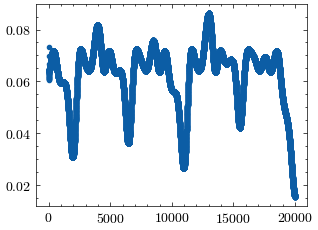

In [330]:
plt.plot(range(20000),y_thick.T[0],'.')

In [113]:
ρ_res = np.array([outputs_traced[i][200] for i in range(2)])

In [114]:
outputs_traced = np.zeros((2, dim, 2**(Nq-1), 2**(Nq-1)), dtype = complex)
for i in tqdm(range(2)):
    outputs = qs.collisions(ρ, ρ_res[i], H, δt, tstep)
    outputs_traced[i] = qs.ptrace(outputs, [k for k in range(1,Nq)])

100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
c:\Users\marco\Desktop\Università\PhD\quantum_env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part


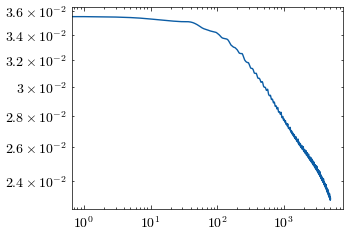

In [153]:
dist = qs.distance(outputs_traced[0], outputs_traced[1])[1:]
plt.loglog(range(0,dist.shape[0]), dist)

In [148]:
dist[200]

np.complex128(0.007359294897826841+1.429569191464057e-22j)